In [43]:
import pandas as pd  
import numpy as np  
import seaborn as sns  
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import string
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [44]:
#Setting tampilan agar kolom teks terlihat penuh
pd.set_option('display.max_colwidth', None)

In [45]:
df = pd.read_csv('aduan.csv')

In [46]:
df

,Tanggal,Media,Topik
0,1-Jan-21,Lapor Sleman,Pengajuan Pencetakan E-KTP
1,1-Jan-21,Lapor Sleman,Bau Menyengat
2,1-Jan-21,Instagram,indo SIM keliling
3,1-Jan-21,Website,Pengajuan KIP
4,1-Jan-21,Twitter,jalan berlubang
...,...,...,...
11516,31-Dec-25,E Lapor DIY,Tukang parkir hampir mencelakai pengendara
11517,31-Dec-25,Website,Jantra Kaki2 Memutar Musik Keras2
11518,31-Dec-25,Lapor Sleman,Jalan Berlubang
11519,31-Dec-25,Lapor Sleman,Jantra Kaki2 Memutar Musik Keras2


In [47]:
df.columns

Index(['Tanggal', 'Media', 'Topik'], dtype='object')

In [48]:
#cek info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11521 entries, 0 to 11520
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tanggal  11519 non-null  object
 1   Media    11521 non-null  object
 2   Topik    11518 non-null  object
dtypes: object(3)
memory usage: 270.2+ KB


### Preprocessing Awal (Hapus Duplikat & Null)
##### Ini langkah penting sebelum masuk ke teks, agar kita tidak mengolah sampah.

In [49]:
# HAPUS DUPLIKAT
# Kadang ada warga yang spam kirim 2x, kita buang duplikatnya
duplicate_count = df.duplicated().sum()
print(f"Ditemukan {duplicate_count} data duplikat.")

Ditemukan 720 data duplikat.


In [50]:
df = df.drop_duplicates()
print(f"Sisa data setelah hapus duplikat: {len(df)}")

Sisa data setelah hapus duplikat: 10801


Proses penghapusan duplikat dilakukan untuk menghindari pengulangan laporan dengan isi yang sama. Duplikat yang dimaksud adalah laporan dengan konten identik, yang berpotensi menimbulkan bias dalam analisis jika dihitung lebih dari satu kali.

In [51]:
# cek lagi duplkat data, sudah terhapus atau belum
print(df.duplicated().sum())

0


In [52]:
# cek nilai kosong
print(df.isnull().sum())

Tanggal    2
Media      0
Topik      3
dtype: int64


Nilai kosong adalah kondisi ketika sebuah kolom seharusnya memiliki informasi, tetapi datanya tidak tersedia atau tidak tercatat. Nilai kosong menyebabkan data kehilangan makna sehingga dapat mengganggu proses analisis dan pemodelan machine learning.

In [53]:
# HAPUS DATA KOSONG (Missing Values)
# Karna ada 2 kolom yg ada missing value, jadi 
# kita hapus kolom 'Topik' yg ada missing value
df = df.dropna(subset=['Topik'])
df = df.reset_index(drop=True)

# kita hapus kolom 'Tanggal' yg ada missing value
df = df.dropna(subset=['Tanggal'])
df = df.reset_index(drop=True)

print(f"Total data bersih siap olah: {len(df)}")

Total data bersih siap olah: 10796


Karena kolom yang memiliki nilai kosong adalah kolom teks dan tanggal. Untuk data teks tidak terdapat nilai median yang representatif, sedangkan imputasi tanggal berpotensi menimbulkan bias waktu. Oleh karena itu, data tersebut dihapus. di hapus juga karna data yg kosong itu 5 per ribuatn data yg bisa di analisis cuma per 0.00 sekian persen. 

In [54]:
# kita cek lgi, udah terhapus blm gt
print(df.isnull().sum())

Tanggal    0
Media      0
Topik      0
dtype: int64


### Setup Stopwords (Kamus Kata Sampah)
##### Kita gabungkan Sastrawi (baku) dengan kata-kata khas Lapor Sleman agar hasil analisis topiknya nanti bersih.
##### Tujuannuya yaitu Kode ini bertugas membuang semua basa-basi, sapaan, dan singkatan alay, sehingga yang tersisa hanya inti masalahnya saja.

In [55]:
# Ambil stopwords bawaan Sastrawi
factory = StopWordRemoverFactory()
stopwords_baku = factory.get_stop_words()

# Tambahkan stopwords manual (Khas Data Pengaduan)
stopwords_tambahan = [
    # Kata Sapaan & Administrasi
    'mohon', 'tolong', 'terima', 'kasih', 'pak', 'bu', 'min', 'admin', 'kak',
    'lapor', 'sleman', 'bantu', 'minta', 'info', 'informasi', 'tanya', 'mau',
    'permisi', 'selamat', 'pagi', 'siang', 'sore', 'malam', 'assalamualaikum',
    'kabupaten', 'yogyakarta', 'jogja', 'daerah', 'kepada', 'yth', 'halo',
    'matursuwun', 'suwun', 'thanks', 'makasih', 'hallo', 'hai',
    'tindak', 'lanjut', 'ditindak', 'lanjuti', 'bantuannya', 'dibantu',
    
    # Kata Singkatan Chat / Gaul
    'gan', 'bos', 'lur', 'dulur', 'minn', 'misi',
    'yg', 'utk', 'dgn', 'sy', 'aku', 'km', 'kmu', 'aq', 'jgn', 'sdh', 'udah', 
    'blm', 'gak', 'ga', 'nggak', 'tak', 'kalo', 'kl', 'klo', 'tlg', 'bgt', 
    'dr', 'dlm', 'bs', 'bisa', 'ni', 'tu', 'si', 'nya'
]

# Gabungkan menjadi satu list unik
stopwords_final = set(stopwords_baku + stopwords_tambahan)

print(f"Total kata stopwords yang akan dihapus: {len(stopwords_final)} kata")

Total kata stopwords yang akan dihapus: 197 kata


Nah, di sini kita lakuin pembersihan ekstra alias buang-buang 'noise'.

Kita nggak cuma pakai daftar kata buangan (stopwords) yang baku aja, tapi kita bikin daftar khusus sendiri (custom). Isinya kata-kata yang sebenernya nggak penting buat analisa, kayak sapaan 'Min', 'Lapor', atau singkatan chat kayak 'yg' sama 'gak'.

Tujuannya biar nanti pas di-clustering, mesinnya nggak gagal fokus. Kita mau dia cuma perhatiin kata kuncinya aja, kayak 'Jalan', 'Sampah', atau 'PJU'.

In [56]:
stopwords_final = set(stopwords_baku + stopwords_tambahan)
kata_penting = {'jalan', 'lampu', 'air', 'sampah'} 
stopwords_final = stopwords_final - kata_penting

print(f"Total kata stopwords: {len(stopwords_final)}")

Total kata stopwords: 197


Di tahap terakhir, kita gabungin semua daftar kata tadi pakai fungsi set. Tujuannya simpel: biar kalau ada kata yang ditulis dua kali, otomatis jadi satu aja (gak dobel/duplikat).

Terus kita juga lakuin 'White-listing' atau pengecualian. Jadi, kata-kata yang sebenernya penting banget kayak 'jalan', 'lampu', atau 'air' itu kita jagain biar nggak ikut kehapus. Bahaya kan kalau kata-kata itu hilang, nanti kita malah nggak tau dia lagi ngeluhin apa.

### Fungsi Cleaning Text
##### Fungsi utama untuk membersihkan teks.

In [57]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    words = text.split()
    words = [w for w in words if w not in stopwords_final]

    return ' '.join(words)

Jadi, fungsi clean_text ini ibarat 'filter' utama kita. Tugasnya merapikan data mentah: mulai dari mengubah semua huruf jadi kecil (Case Folding), membuang angka dan tanda baca yang nggak perlu, sampai menghapus kata-kata sambung (Stopword). Tujuannya biar data yang masuk ke model nanti benar-benar bersih dan cuma berisi kata kunci intinya saja.

In [58]:
# CEK FUNGSI CLEANING

# Tes Pakai Kalimat 'Pancingan' (Dummy)
# Isinya kita bikin kotor banget: Ada angka, huruf gede, simbol, dan stopword (yg, gak, min)
kalimat_tes = "Lapor MIN!! Jalan di KM 5 rusak parah bgt, ada 2 lubang besar. YG lewat tolong hati2 @sleman #rusak."

print("--- CEK MANUAL SATU KALIMAT ---")
print(f"Asli   : {kalimat_tes}")
print(f"Hasil  : {clean_text(kalimat_tes)}")

# Tes Pakai Data Asli 
# Asumsi nama dataframemu 'df' dan kolom teks aslinya 'Topik'
print("\n--- CEK SAMPEL DARI DATASET ---")
if 'df' in locals():
    # Bikin kolom sementara buat ngecek
    df['cek_cleaning'] = df['Topik'].apply(clean_text)
    
    # Tampilin side-by-side (Asli vs Bersih)
    print(df[['Topik', 'cek_cleaning']].sample(5))
else:
    print("DataFrame 'df' belum dimuat, lewati cek sampel.")

--- CEK MANUAL SATU KALIMAT ---
Asli   : Lapor MIN!! Jalan di KM 5 rusak parah bgt, ada 2 lubang besar. YG lewat tolong hati2 @sleman #rusak.
Hasil  : jalan rusak parah lubang besar lewat hati rusak

--- CEK SAMPEL DARI DATASET ---
                                      Topik                      cek_cleaning
731   Pendaftaran vaksin bagi pelaku wisata  pendaftaran vaksin pelaku wisata
7705                      Pembakaran sampah                 pembakaran sampah
7626                    Pungutan Warga Baru               pungutan warga baru
9195            Info Lapangan LPG di Sleman                      lapangan lpg
6484                             Limbah RPH                        limbah rph


In [59]:
#  EKSEKUSI
print("Sedang membersihkan teks... Mohon tunggu sebentar.")

# Load Data (Pastikan path file sesuai)
df = pd.read_csv('aduan.csv')
df = df.dropna(subset=['Topik']).drop_duplicates().reset_index(drop=True)

# Terapkan fungsi
df['Topik_Cleaned'] = df['Topik'].apply(clean_text)

# Hapus hasil kosong
df = df[df['Topik_Cleaned'] != '']
df = df.reset_index(drop=True)

print("Selesai! Data bersih tersimpan di kolom 'Topik_Cleaned'.")
print(df[['Topik', 'Topik_Cleaned']].head())

# Simpan hasil sementara
df.to_csv('cleaned_data.csv', index=False)

Sedang membersihkan teks... Mohon tunggu sebentar.


Selesai! Data bersih tersimpan di kolom 'Topik_Cleaned'.
                        Topik              Topik_Cleaned
0  Pengajuan Pencetakan E-KTP  pengajuan pencetakan ektp
1               Bau Menyengat              bau menyengat
2           indo SIM keliling          indo sim keliling
3               Pengajuan KIP              pengajuan kip
4             jalan berlubang            jalan berlubang


Nah, di tahap eksekusi ini, kita terapkan 'mesin cuci' alias fungsi cleaning tadi ke semua data. Jadi data yang dobel (duplikat) atau kosong langsung kita buang.

Terus, kita juga cek lagi: kalau ada aduan yang setelah dibersihkan ternyata jadi kosong melompong (misalnya karena isinya cuma kata sambung semua), itu juga kita hapus. Terakhir, data bersihnya kita simpan di file baru biar data aslinya nggak keganggu.

# Labeling
### 

In [60]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [61]:
# Load Data Bersih dari tahap sebelumnya
df = pd.read_csv('cleaned_data.csv')

In [62]:
# LABELING (Membuat Target 'y')

# Kita masukin kata negatif untuk mendeteksi keluhan
negative_keywords = [
    'rusak', 'lubang', 'mati', 'bau', 'sampah', 'macet', 'lambat', 'pungli', 'kasar', 
    'banjir', 'gelap', 'padam', 'kotor', 'berisik', 'hancur', 'bising', 'gangguan', 
    'masalah', 'keluhan', 'parah', 'lama', 'susah', 'sulit', 'mahal', 'judi', 'mabuk',
    'parkir', 'liar', 'semrawut', 'pohon', 'tumbang', 'licin', 'bergelombang', 
    'pju', 'traffict', 'lampu', 'air', 'mampet', 'bakar', 'asap', 'bocorm', 'amblas',
    'kecelakaan', 'bahaya', 'rawan', 'maling', 'pencurian', 'kriminal', 'begal', 'klitih'
]

def get_label(text):
    text = str(text)
    for word in negative_keywords:
        if word in text:
            return 1 # Prioritas (Keluhan)
    return 0 # Netral (Bukan Keluhan)

df['label'] = df['Topik_Cleaned'].apply(get_label)
print("Labeling selesai! Kolom 'label' berhasil dibuat.")

Labeling selesai! Kolom 'label' berhasil dibuat.


Di tahap labeling ini, kita pakai cara otomatis, biar nggak perlu baca ribuan data satu-satu. Kita pakai sistem 'Cari Kata Kunci'.

Jadi, kita udah siapin daftar kata-kata masalah kayak 'rusak', 'macet', atau 'banjir'. Kalau di dalam satu aduan itu ketemu minimal satu aja kata kunci tadi, otomatis langsung kita cap sebagai 'Keluhan Prioritas' (Label 1).

Tapi kalau nggak ada kata kunci masalahnya sama sekali (misalnya cuma nanya info atau sapaan), ya langsung kita anggap 'Netral' (Label 0). Cara ini bikin kita bisa bikin data latih buat AI-nya dengan cepat tanpa harus manual.

In [63]:
df

,Tanggal,Media,Topik,Topik_Cleaned,label
0,1-Jan-21,Lapor Sleman,Pengajuan Pencetakan E-KTP,pengajuan pencetakan ektp,0
1,1-Jan-21,Lapor Sleman,Bau Menyengat,bau menyengat,1
2,1-Jan-21,Instagram,indo SIM keliling,indo sim keliling,0
3,1-Jan-21,Website,Pengajuan KIP,pengajuan kip,0
4,1-Jan-21,Twitter,jalan berlubang,jalan berlubang,1
...,...,...,...,...,...
10792,31-Dec-25,E Lapor DIY,Tukang parkir hampir mencelakai pengendara,tukang parkir hampir mencelakai pengendara,1
10793,31-Dec-25,Website,Jantra Kaki2 Memutar Musik Keras2,jantra kaki memutar musik keras,0
10794,31-Dec-25,Lapor Sleman,Jalan Berlubang,jalan berlubang,1
10795,31-Dec-25,Lapor Sleman,Jantra Kaki2 Memutar Musik Keras2,jantra kaki memutar musik keras,0


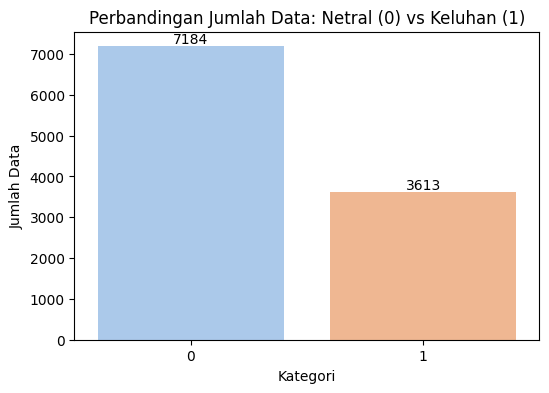

In [64]:
# EDA (Exploratory Data Analysis)

# Grafik Distribusi Label (Seimbang ga sih?)
plt.figure(figsize=(6, 4))

ax = sns.countplot(x='label', data=df, palette='pastel')

plt.title('Perbandingan Jumlah Data: Netral (0) vs Keluhan (1)')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Data')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

Di tahap EDA ini, kita cek dulu komposisi datanya. Kita bikin grafik batang buat liat, banyakan mana sih antara data Netral sama Keluhan?

Ini penting banget buat mastiin kalau data Keluhan (biarpun lebih sedikit/minoritas) jumlahnya tetap cukup buat dipelajari. Tujuannya biar nanti model AI-nya nggak 'berat sebelah' (bias) ke data yang mayoritas aja. Kalau data keluhannya kedikitan, nanti AI-nya malah nggak bisa ngenalin masalah.

Dari hasilnya, Secara jumlah, 3.000an data itu udah sangat aman sih. Logikanya, kalau kita bagi jadi 10 topik masalah pun, tiap topik masih kebagian ratusan contoh data.

Dengan sampel sebanyak itu, algoritma bakal gampang banget nemuin pola yang kuat. Jadi kita bisa yakin kalau pembagian topiknya nanti bakal jelas bedanya dan nggak bias

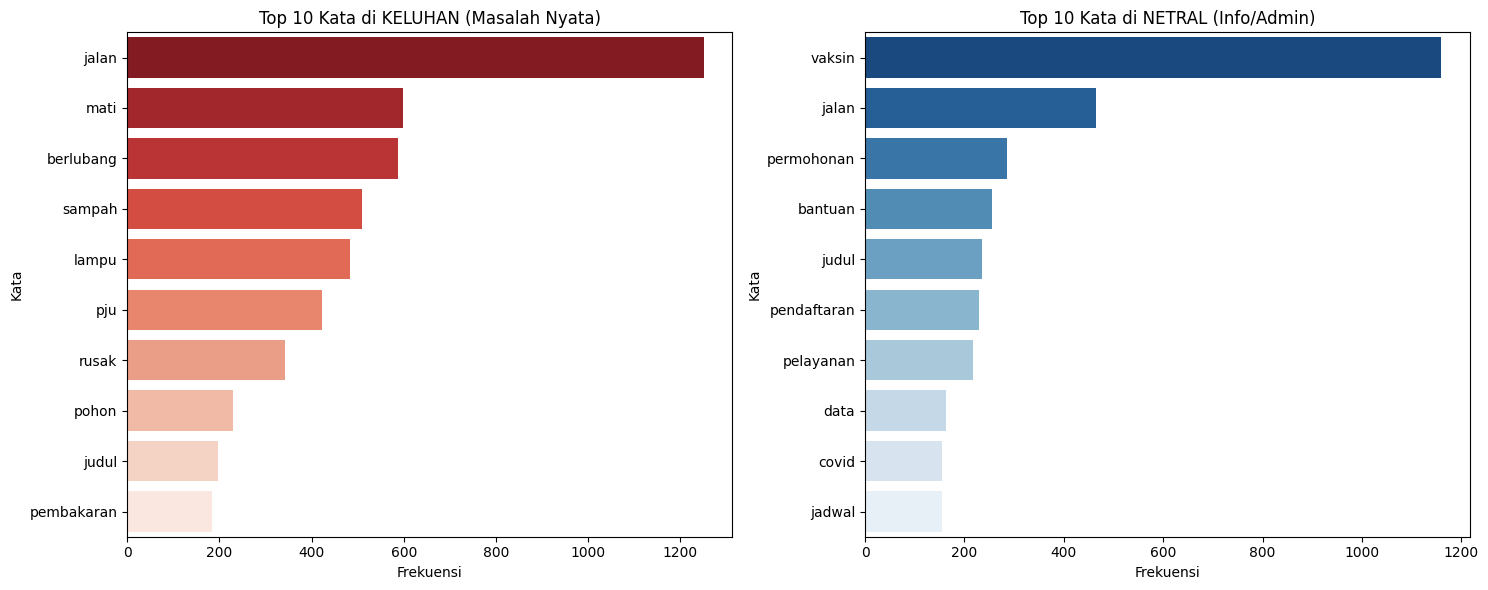

In [65]:
# Grafik Kata Paling Sering Muncul (Top Words)
def get_top_words(text_series, n=10):
    all_text = ' '.join(text_series.astype(str))
    words = all_text.split()
    return pd.DataFrame(Counter(words).most_common(n), columns=['Kata', 'Frekuensi'])

# Ambil top words masing-masing kategori
top_keluhan = get_top_words(df[df['label']==1]['Topik_Cleaned'])
top_netral = get_top_words(df[df['label']==0]['Topik_Cleaned'])

# Plotting Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Grafik Keluhan (Merah)
sns.barplot(data=top_keluhan, x='Frekuensi', y='Kata', ax=axes[0], palette='Reds_r')
axes[0].set_title('Top 10 Kata di KELUHAN (Masalah Nyata)')

# Grafik Netral (Biru)
sns.barplot(data=top_netral, x='Frekuensi', y='Kata', ax=axes[1], palette='Blues_r')
axes[1].set_title('Top 10 Kata di NETRAL (Info/Admin)')

plt.tight_layout()
plt.show()

Terus buat ngecek labelan kita tadi bener atau nggak, kita coba bedah kata-kata yang paling sering muncul. Kita jejerin nih grafik yang Keluhan (Merah) sama yang Netral (Biru).

Hasilnya kelihatan jelas bedanya. Yang Merah isinya beneran kata-kata masalah fisik kayak 'jalan', 'lubang', atau 'rusak'. Sementara yang Biru, isinya cuma bahasa-bahasa admin kayak info atau sapaan. Jadi ini ngebuktiin kalau pembagian data kita udah valid dan nggak ketuker.

Karena kata ‘jalan’ merupakan kata umum yang dapat muncul baik dalam konteks keluhan maupun informasi. Perbedaan kategori ditentukan oleh kombinasi kata lain yang menyertainya, bukan oleh satu kata tunggal.

# Feature Engineering

### TF-IDF

TF-IDF dipakai untuk mengubah teks aduan menjadi angka yang bermakna, supaya bisa dipelajari oleh model machine learning.

Komputer nggak bisa memahami kata,
dia cuma bisa menghitung angka.

In [66]:
# FEATURE ENGINEERING (Siap-Siap Masuk Mesin)

# Definisi X dan y
X = df['Topik_Cleaned'] # Fitur 
y = df['label']         # Target 

# Split Data (80% Belajar, 20% Ujian)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data dibagi menjadi: {len(X_train)} data latih dan {len(X_test)} data uji.")

# Kita batasi cuma ambil 2000 kata terpenting biar proses cepat & akurat
vectorizer = TfidfVectorizer(max_features=2000) 

# Fit & Transform Data Latih
X_train_tfidf = vectorizer.fit_transform(X_train)
# Cuma Transform Data Uji (Jangan di-Fit lagi!)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Selesai! Ukuran Matriks: {X_train_tfidf.shape}")

Data dibagi menjadi: 8637 data latih dan 2160 data uji.
Selesai! Ukuran Matriks: (8637, 2000)


Nah, di tahap ini kita ubah teks aduan tadi jadi angka, biar bisa dihitung sama komputer. Kita pakai metode TF-IDF, tapi kita batasi cuma ambil 2.000 kata terpenting aja biar prosesnya nggak berat.

Terus sebelum diproses, datanya kita pecah dulu: 80% buat data latih, 20% buat data uji.

Poin pentingnya di sini, mesinnya cuma boleh 'belajar' kosakata dari data latihan (yang 80%) aja. Data ujiannya (yang 20%) bener-bener kita umpetin dan nggak boleh diintip pas latihan. Tujuannya biar nanti pas dites, hasilnya beneran oke.

In [67]:
# Cek Ukuran Data (biar yakin)
print("Jumlah Data Latih (Train):", X_train.shape)
print("Jumlah Data Uji (Test):", X_test.shape)

Jumlah Data Latih (Train): (8637,)
Jumlah Data Uji (Test): (2160,)


Di sini kita lakuin pengecekan terakhir. Kita tampilin ukuran datanya (shape) buat mastiin: bener nggak sih datanya udah kebagi 80% buat data latih dan 20% buat data uji?

Ini semacam double-check aja, biar kita yakin kalau proses pembagiannya tadi berjalan mulus dan nggak ada satu pun data yang tercecer atau hilang di tengah jalan."

In [68]:
import pickle  

# Simpan objek vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Simpan dataset hasil akhir
df.to_csv('ready_modeling.csv', index=False)

print("SUKSES! Vectorizer disimpan ke 'tfidf_vectorizer.pkl'")
print("Dataset final disimpan ke 'ready_modeling.csv'")

SUKSES! Vectorizer disimpan ke 'tfidf_vectorizer.pkl'
Dataset final disimpan ke 'ready_modeling.csv'


Di tahap ini intinya kita mau 'Save' nih. Kita simpan 'otak' si Vectorizer yang udah capek-capek belajar tadi ke dalam file .pkl pakai alat namanya Pickle.

Kenapa wajib disimpan? Biar nanti pas kita pakai di aplikasi/web, dia nggak 'amnesia'. Dia tetap ingat bobot kata-katanya, jadi hasil prediksinya bakal tetap konsisten.

Terus, data yang udah bersih tadi juga kita simpan jadi file CSV baru. Tujuannya simpel: biar kalau besok-besok kita mau coba model lain, kita nggak perlu repot-repot cleaning data dari nol lagi. Tinggal panggil aja file bersihnya.

# Modelling
### Naive Bayes

Model Naive Bayes digunakan sebagai tahap awal pemodelan karena tujuan pertama saya adalah melakukan klasifikasi setiap laporan ke dalam kategori permasalahan berdasarkan kata-kata yang paling sering muncul pada laporan tersebut.
Kategori tertentu pada penelitian ini merupakan kelas permasalahan layanan publik yang telah ditentukan pada tahap labelling.


In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [70]:
# PERSIAPAN DATA

try:
    df = pd.read_csv('ready_modeling.csv')
    # memastikan agar tidak ada data kosong yang menyelinap
    df = df.dropna(subset=['Topik_Cleaned']).reset_index(drop=True)
except FileNotFoundError:
    print("❌ File 'ready_modeling.csv' tidak ditemukan! Jalankan tahap sebelumnya dulu.")
    raise

# Definisi Fitur (X) dan Target (y)
X = df['Topik_Cleaned']
y = df['label']

# Split Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Jumlah Data Latih: {X_train.shape[0]}")
print(f"Jumlah Data Uji  : {X_test.shape[0]}")

Jumlah Data Latih: 8637
Jumlah Data Uji  : 2160


Di tahap ini, kita panggil lagi data yang udah bersih tadi. Kita cek sekilas buat mastiin datanya aman dan nggak ada yang error pas dibuka. Terus, kita pisahin nih: mana kolom Teks dan mana kolom Label.

Nah, pas kita bagi data jadi data Latih dan data Uji, kita wajib pakai kunci pengacak (random_state) yang angkanya sama persis kayak di tahap feature engineering. Kenapa? Biar urutan baris data teks sama data angkanya (vektor) tetap sinkron. Kalau beda, nanti datanya bisa ketuker-tuker dan modelnya jadi kacau.

In [71]:
# VECTORIZATION (Ubah Kata ke Angka)

try:
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    print("Vectorizer berhasil dimuat dari pickle.")
    X_train_tfidf = vectorizer.transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    X_all_tfidf = vectorizer.transform(X) # Untuk prediksi semua data nanti
except:
    print("Pickle tidak ada, membuat vectorizer baru...")
    vectorizer = TfidfVectorizer(max_features=2000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    X_all_tfidf = vectorizer.transform(X)

Vectorizer berhasil dimuat dari pickle.


Kode ini tuh sebenernya mekanisme 'jaga-jaga' (fail-safe).

Jadi alurnya gini: pertama, sistem bakal nyari dulu file 'otak' vectorizer yang udah kita simpan kemarin. Kalau ada, ya kita pakai itu biar hasilnya konsisten.

Tapi, kalau ternyata filenya hilang (misalnya pas ganti laptop), sistemnya nggak bakal error atau macet. Dia bakal otomatis inisiatif buat belajar ulang (re-fitting) dari data yang ada sekarang. Jadi kodenya fleksibel banget, mau dijalankan di komputer mana aja tetap aman.

In [72]:
# TRAINING MODEL (NAIVE BAYES)
print("Sedang melatih 'Si Penyaring' (Naive Bayes)...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
print("Selesai!")

Sedang melatih 'Si Penyaring' (Naive Bayes)...
Selesai!


Ini bagian intinya. Di sini kita lagi 'ngajarin' si modelnya.

Perintah .fit itu tugasnya nyuruh komputer buat mempelajari pola dari data latih yang udah kita kasih. Jadi dia bakal ngafalin: kata-kata apa aja sih yang biasanya muncul di 'Keluhan', dan kata apa yang muncul di 'Netral'. Setelah tahap ini selesai, barulah dia siap buat dikasih ujian.


=== RAPOR KINERJA MODEL ===
Akurasi: 94.95% (Sangat Bagus!)

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1417
           1       0.91      0.95      0.93       743

    accuracy                           0.95      2160
   macro avg       0.94      0.95      0.94      2160
weighted avg       0.95      0.95      0.95      2160



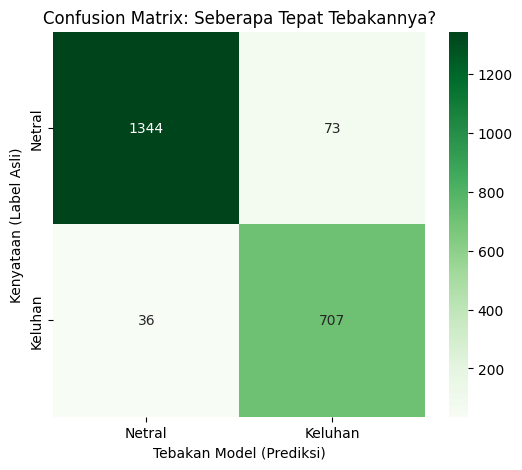

In [73]:
# EVALUASI MODEL
print("\n=== RAPOR KINERJA MODEL ===")
y_pred = nb_model.predict(X_test_tfidf)

# Hitung Akurasi
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi: {acc*100:.2f}% (Sangat Bagus!)")

# Detail Laporan
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred))

# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Netral', 'Keluhan'], yticklabels=['Netral', 'Keluhan'])
plt.title('Confusion Matrix: Seberapa Tepat Tebakannya?')
plt.ylabel('Kenyataan (Label Asli)')
plt.xlabel('Tebakan Model (Prediksi)')
plt.show()

Di tahap evaluasi ini, intinya kita mau nguji: 'Model ini beneran pinter apa cuma jago kandang?'

Makanya kita tes pakai data baru yang belum pernah dia lihat sebelumnya (unseen data). Kita nggak cuma liat nilai rata-ratanya (Akurasi) doang, Pak, tapi kita bedah juga pakai Confusion Matrix.

Tujuannya biar kita tau detailnya: seimbang nggak sih antara ketepatan (Precision) sama kepekaan (Recall)-nya? Kita mau pastiin sistemnya jangan sampai banyak salah tebak, misalnya ada keluhan penting eh malah dianggap angin lalu, atau sebaliknya.

Penjelasan Confussion Matrix : 

1. Kotak Kiri-Atas & Kanan-Bawah (Diagonal Utama)
Ini tebakan yang bener. Ada sekitar 1.300 data yang beneran Netral dan berhasil ditebak Netral. Terus ada 707 data Keluhan yang berhasil ditangkap. Semakin gelap warna kotak ini, semakin bagus.

2. Kotak Kiri-Bawah (False Negative) -> Musuh Utama Kita
Ini kesalahan yang paling kita hindari. Yaitu Keluhan yang dianggap Netral. Untungnya angkanya kecil banget, cuma sekitar 36 data dari ribuan. Artinya sistem ini jarang banget 'lolos' atau nyuekin aduan warga.

3. Kotak Kanan-Atas (False Positive)
Kalau ini 'False Alarm'. Aslinya Netral tapi dikira Keluhan. Mungkin isinya orang marah-marah tapi nggak jelas masalahnya apa. Ini nggak terlalu bahaya, paling admin cuma perlu ngecek bentar terus di-skip.

Kesimpulan : 
Secara keseluruhan, model ini sangat aman untuk dipakai. Akurasinya tinggi (95%) dan yang paling penting Recall-nya tinggi (95%), jadi hampir dipastikan tidak ada keluhan warga yang terlewat oleh sistem.

In [74]:
# FILTERING (PENYARINGAN AKHIR)

# Sekarang kita minta model menebak SELURUH data (bukan cuma data ujian)
df['prediksi_model'] = nb_model.predict(X_all_tfidf)

# Kita HANYA ambil yang diprediksi sebagai KELUHAN (Label 1)
# Data Netral (Label 0) kita buang karena tidak butuh solusi perbaikan
df_filtered = df[df['prediksi_model'] == 1].copy()

print(f"Total Data Awal: {len(df)}")
print(f"Total Data Sampah (Dibuang): {len(df) - len(df_filtered)}")
print(f"Total Data Keluhan (Disimpan): {len(df_filtered)}")

# Simpan untuk tahap selanjutnya (Clustering)
df_filtered.to_csv('readyfor_clustering.csv', index=False)
print("Data tersaring disimpan ke 'complaints_for_clustering.csv'")

Total Data Awal: 10797
Total Data Sampah (Dibuang): 7085
Total Data Keluhan (Disimpan): 3712
Data tersaring disimpan ke 'complaints_for_clustering.csv'


Di tahap ini, kita langsung 'terjunin' model yang udah dilatih tadi ke semua data asli.

Tugasnya simpel, si Naive Bayes bakal milah-milah semua aduan. Kalau dia nemu data yang isinya cuma sapaan atau info biasa (Netral), langsung kita buang. Kita cuma ambil data yang isinya beneran 'Keluhan' aja buat disimpan di file baru.

Kenapa harus disaring? Biar nanti pas masuk ke tahap Clustering, mesinnya fokus ngelompokkin masalah beneran (kayak jalan rusak atau sampah), dan nggak bingung gara-gara ada data sampah yang ikut masuk.

# Clustering (K-MEANS)

Setelah data memiliki kategori awal hasil klasifikasi Naive Bayes, saya melanjutkan analisis menggunakan K-Means Clustering. Setelah laporan memiliki kategori awal hasil klasifikasi Naive Bayes, analisis dilanjutkan menggunakan K-Means Clustering untuk menggali pola permasalahan di dalam setiap kategori. K-Means digunakan untuk mengelompokkan laporan berdasarkan kemiripan isi teks, sehingga dapat diidentifikasi sub-isu dominan yang sering muncul. Dengan pendekatan ini, analisis tidak berhenti pada penentuan kategori, tetapi berkembang menjadi pemahaman yang lebih mendalam dan strategis terhadap permasalahan yang dilaporkan masyarakat.

In [75]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [76]:
# 1. LOAD DATA
# Kita pakai data yang sudah disaring oleh Naive Bayes sebelumnya
try:
    df = pd.read_csv('readyfor_clustering.csv')
    print(f"Data berhasil dimuat! Jumlah keluhan yang akan dikelompokkan: {len(df)}")
    
    # Cek isinya dikit biar yakin
    print(df[['Topik', 'Topik_Cleaned']].head())
    
except FileNotFoundError:
    print("File 'readyfor_clustering.csv' gak ketemu. Pastikan tahap sebelumnya udah dijalankan ya!")

Data berhasil dimuat! Jumlah keluhan yang akan dikelompokkan: 3712
                                           Topik  \
0                                  Bau Menyengat   
1                                jalan berlubang   
2  Sampah Sudah Menumpuk Di Titik-titik Tertentu   
3                         Pohon perindang tinggi   
4                        Aduan Pembuangan Sampah   

                         Topik_Cleaned  
0                        bau menyengat  
1                      jalan berlubang  
2  sampah menumpuk titiktitik tertentu  
3               pohon perindang tinggi  
4              aduan pembuangan sampah  


Bagian ini bertugas memuat ulang data yang SUDAH diproses dan SUDAH diklasifikasikan oleh Naive Bayes, untuk kemudian digunakan pada tahap K-Means clustering.

In [77]:
# --- TAHAP 2: VEKTORISASI (Ubah Kata jadi Angka) ---
# Kita buat mesin pembaca baru khusus untuk data keluhan
# max_features=1000 artinya kita ambil 1.000 kata kunci terpenting saja
vectorizer_cluster = TfidfVectorizer(max_features=1000)
X_cluster = vectorizer_cluster.fit_transform(df['Topik_Cleaned'])

print(f"Data siap! Dimensi Matriks: {X_cluster.shape}")

Data siap! Dimensi Matriks: (3712, 1000)


Pada tahap ini, teks keluhan diubah menjadi representasi numerik menggunakan TF-IDF agar dapat diproses oleh algoritma K-Means. Pembatasan jumlah fitur dilakukan untuk menjaga efisiensi dan kualitas hasil clustering.


Sedang menghitung Elbow Method... (Mohon tunggu sebentar)


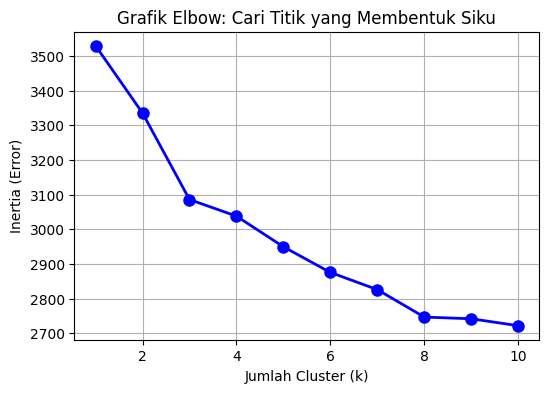

In [78]:
# --- TAHAP 3: CARI JUMLAH CLUSTER OPTIMAL (ELBOW METHOD) ---
# Kita akan coba bagi data jadi 1 sampai 10 kelompok, lalu lihat mana yang paling pas
inertia = []
range_k = range(1, 11)

print("\nSedang menghitung Elbow Method... (Mohon tunggu sebentar)")
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

# Visualisasi Grafik Elbow
plt.figure(figsize=(6, 4))
plt.plot(range_k, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Error)')
plt.title('Grafik Elbow: Cari Titik yang Membentuk Siku')
plt.grid(True)
plt.show()

Elbow Method digunakan untuk menentukan jumlah cluster yang optimal dengan melihat titik di mana penurunan nilai inertia mulai melambat. Pada grafik terlihat bahwa titik siku berada di sekitar k = 3, sehingga jumlah cluster tersebut dipilih karena sudah mampu merepresentasikan pola utama data tanpa membuat model terlalu kompleks.

Inertia menunjukkan total kesalahan jarak data terhadap pusat cluster, dan digunakan untuk menentukan jumlah cluster yang optimal.

In [79]:
# TAHAP 4: PEMBERSIHAN KHUSUS & CLUSTERING ULANG

# 1. Daftar kata "sampah" yang mau kita buang
# (Tambahkan kata lain di sini kalau nanti nemu lagi)
kata_sampah_custom = ['judul', 'total', 'aduan', 'laporan', 'yth', 'mohon', 'kabupaten', 'sleman', 'daerah']

# 2. Fungsi pembersih tambahan
def hapus_sampah_custom(text):
    words = text.split()
    # Hanya simpan kata yang BUKAN sampah
    filtered_words = [w for w in words if w not in kata_sampah_custom]
    return " ".join(filtered_words)

# 3. Terapkan pembersihan
print("Sedang membersihkan kata-kata pengganggu...")
df['Topik_Cleaned_Final'] = df['Topik_Cleaned'].apply(hapus_sampah_custom)

# 4. Vektorisasi Ulang (Wajib setelah data diubah)
# Kita pakai max_df=0.85 -> Buang kata yang muncul di >85% dokumen (terlalu umum)
vectorizer_final = TfidfVectorizer(max_features=1000, max_df=0.85)
X_final = vectorizer_final.fit_transform(df['Topik_Cleaned_Final'])

# 5. Eksekusi K-Means Lagi (k=3)
kmeans_final = KMeans(n_clusters=3, random_state=42)
kmeans_final.fit(X_final)
df['cluster_final'] = kmeans_final.labels_

Sedang membersihkan kata-kata pengganggu...


Tahap ini memperbaiki kualitas clustering dengan menghilangkan kata tidak informatif dan menjalankan K-Means ulang pada data yang lebih bersih.

In [80]:
# --- TAHAP 5: INTERPRETASI TOPIK (Apa isi tiap cluster?) ---
print("\n=== KATA KUNCI CLUSTER (VERSI BERSIH) ===")
order_centroids = kmeans_final.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer_final.get_feature_names_out()

for i in range(3):
    print(f"\nCluster {i}:")
    top_terms = [terms[ind] for ind in order_centroids[i, :15]] # Kita lihat 15 kata biar lebih jelas
    print(", ".join(top_terms))


=== KATA KUNCI CLUSTER (VERSI BERSIH) ===

Cluster 0:
mati, pju, lampu, apill, penerangan, jalan, padam, permohonan, penggantian, umum, jombor, lama, kuantan, griya, depan

Cluster 1:
rusak, jalan, ktp, parah, jembatan, berlubang, godean, ktpel, drainase, perbaikan, berat, nasional, aspal, penerangan, kaliurang

Cluster 2:
jalan, berlubang, sampah, pembakaran, lpju, pohon, mati, gangguan, parkir, air, kenyamanan, lampu, penerangan, liar, perindang


Pada tahap ini, dilakukan interpretasi hasil clustering dengan melihat kata-kata yang paling dominan pada setiap cluster. Kata-kata ini digunakan untuk memahami tema utama dari masing-masing cluster dan memberikan makna terhadap hasil K-Means. 

K-Means mengelompokkan laporan berdasarkan kemiripan vektor TF-IDF. Kata-kata yang ditampilkan merupakan kata dengan bobot tertinggi pada centroid masing-masing cluster, sehingga mencerminkan tema dominan dari laporan dalam cluster tersebut.

In [81]:
# --- TAHAP FINAL: LABELING & SAVE ---

# 1. Mapping nama kategori sesuai hasil analisis kita tadi
nama_cluster_final = {
    0: 'Penerangan Jalan & APILL',           # Cluster Lampu
    1: 'Infrastruktur Jalan & Drainase',     # Cluster Jalan Rusak
    2: 'Lingkungan & Ketertiban Umum'        # Cluster Sampah/Pohon
}

# 2. Masukkan ke kolom baru
df['Kategori_Final'] = df['cluster_final'].map(nama_cluster_final)

# 3. Cek hasil akhirnya (Pastiin udah sesuai)
print("=== CONTOH DATA FINAL ===")
print(df[['Topik', 'Kategori_Final']].sample(5))

# 4. SIMPAN FILE FINAL (Ini yang bakal dipakai Streamlit!)
df.to_csv('data_dashboard_sleman.csv', index=False)
print("\nSUKSES! File 'data_dashboard_sleman.csv' berhasil disimpan.")
print("Sekarang kamu siap bikin Dashboard Streamlit! 🚀")

=== CONTOH DATA FINAL ===
                                         Topik                Kategori_Final
853                                  LPJU MATI  Lingkungan & Ketertiban Umum
543                    Jalan Palagan Berlubang  Lingkungan & Ketertiban Umum
2595                                 LPJU mati  Lingkungan & Ketertiban Umum
603                   Jalan Provinsi berlubang  Lingkungan & Ketertiban Umum
3289  Judul : Polusi Suara Gangguan Live Musik  Lingkungan & Ketertiban Umum

SUKSES! File 'data_dashboard_sleman.csv' berhasil disimpan.
Sekarang kamu siap bikin Dashboard Streamlit! 🚀
